# <font >Big Data Real-Time Analytics com Python e Spark</font>


### <font >Prevendo a Cotação de Criptomoedas em Tempo Real com PySpark e Machine Learning</font>

![title](imagens/cripto.jpg)

## Objetivo

O objetivo deste projeto é usar um importante contexto de negócio (área de finanças) para estudar ferramentas de análise de dados comuns no dia a dia de um Cientista de Dados. Vamos abordar o projeto desde a concepção do problema de negócio a ser resolvido até a entrega do modelo preditivo. 

## Definição do problema e fonte de dados

O objetivo deste projeto será construir um modelo de Machine Learning capaz de prever a cotação de criptomoedas. Usaremos dados sobre o Bitcoin.

Bitcoin é a criptomoeda mais antiga e conhecida, lançada pela primeira vez como código aberto em 2009 pelo anônimo Satoshi Nakamoto.  O Bitcoin serve como um meio descentralizado de troca digital, com transações  verificadas e registradas em um livro público distribuído (a Blockchain) sem a necessidade de  uma autoridade de manutenção de registros ou intermediário central.  Os blocos de transação contêm um hash criptográfico SHA-256 de blocos de transação  anteriores e, portanto, são "encadeados" juntos, servindo como um registro imutável de todas as transações que já ocorreram. 

Usaremos dados históricos de cotação do Bitcoin de 2011 a 2021. O dataset está sendo fornecido a você e os dados foram extraídos do site abaixo:

https://bitcoincharts.com/charts/


Em função do tamanho do arquivo, optamos por realizar uma divisão dos dados, em porções menores, para aplicar as etapas de analise exploratória, processamento, criação e otimização do modelo, sem comprometer o processamento dos dados.


## Imports

In [2]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [3]:
# Importa o findspark e inicializa
import findspark
findspark.init()

In [4]:
# Imports
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## Preparando o Ambiente Spark

In [6]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [7]:
# Criando o Spark Context
sc = SparkContext(appName = "Mini-Projeto3")

In [8]:
# Criando a sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [9]:
# Visualiza o objeto spark_session
spark_session

## Carregando os dados

Em função do tamanho do arquivo, optamos por realizar uma divisão dos dados, em porções menores, para aplicar as etapas de analise exploratória, processamento, criação e otimização do modelo, sem comprometer o processamento dos dados.

Para realizar a divisão dos dados, criamos uma função que faz a leitura do dataset principal e particiona em número de porções pré-definidas na função.

In [10]:
# Split dos dados

import os

input_file = 'dados/dataset.csv'
chunk_size = 1000000

# Especifique o diretório de saída
output_directory = 'dados/'

# Abra o arquivo de entrada
with open(input_file, 'r') as file:
    lines = file.readlines()
    header = lines[0]  # Lê a primeira linha como o cabeçalho

# ...

for i in range(0, len(lines), chunk_size):
    chunk = lines[i : i + chunk_size]
    
    # Crie o caminho completo para o arquivo de saída
    output_file = os.path.join(output_directory, f'porcao_{i // chunk_size}.csv')
    
    with open(output_file, 'w') as output:
        # Escreva o cabeçalho no arquivo de saída
        output.write(header)
        output.writelines(chunk[1:])  # Escreve as linhas de dados, excluindo o cabeçalho

Para realizarmos nossas análises vamos utilizar a última porção do dataset, que apresenta os dados mais recentes da base de dados.

In [11]:
# Carregando os dados a partir da sessão Spark
df_spark = spark_session.read.csv('dados/porcao_4.csv', header = 'true', inferSchema = 'true')

In [12]:
# Tipo do objeto
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [13]:
# Visualizando os dados
df_spark.show()

+----------+--------+--------+--------+--------+------------+-----------------+--------------+
| Timestamp|    Open|    High|     Low|   Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+--------+--------+--------+--------+------------+-----------------+--------------+
|1565752860|10600.12|10604.77|10597.99|10597.99|  0.25703378|     2724.7336264|  10600.683017|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|  0.21695749|     2299.8701409|  10600.556546|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|  1.19255966|     12637.004098|  10596.538288|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|  0.18785115|     1991.5564078|  10601.779163|
|1565753100|10597.09|10606.97|10590.24| 10600.0|   0.3913512|     4145.7622772|   10593.45743|
|1565753160|10606.14|10606.97|10598.62|10598.62|  0.69793703|     7397.8216441|  10599.554582|
|1565753220| 10598.6|10606.97| 10598.6|10606.97|  0.06174562|     654.90722854|  10606.537412|
|1565753280|10606.97|10612.28|10601.52|10601.52|  

In [14]:
# Visualizando os metadados (schema)
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [15]:
# Verificando o numero de linhas
df_spark.count()

856600

## Data Wrangling com SparkSQL

In [16]:
# Cria uma tabela temporária a partir do dataframe
# As tabelas temporárias são úteis quando você deseja que o conjunto de resultados fique visível 
# para todas as outras sessões Spark
df_spark.createOrReplaceTempView('dados_bitcoin') 

In [17]:
# Executando uma consulta SQL
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from dados_bitcoin")

In [18]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [19]:
# Visualiza os dados
df_bitcoin.show()

+----------+--------+--------+--------+--------+------------+-----------------+--------------+-------------------+
| Timestamp|    Open|    High|     Low|   Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+--------+--------+--------+--------+------------+-----------------+--------------+-------------------+
|1565752860|10600.12|10604.77|10597.99|10597.99|  0.25703378|     2724.7336264|  10600.683017|2019-08-14 00:21:00|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|  0.21695749|     2299.8701409|  10600.556546|2019-08-14 00:22:00|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|  1.19255966|     12637.004098|  10596.538288|2019-08-14 00:23:00|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|  0.18785115|     1991.5564078|  10601.779163|2019-08-14 00:24:00|
|1565753100|10597.09|10606.97|10590.24| 10600.0|   0.3913512|     4145.7622772|   10593.45743|2019-08-14 00:25:00|
|1565753160|10606.14|10606.97|10598.62|10598.62|  0.69793703|     7397.8216441| 

In [20]:
# Remove valores NA (não faz sentido qualquer tratamento aqui, pois todas as colunas de cotações estão como NA)
df_bitcoin = df_bitcoin.dropna('any')

In [21]:
# Visualiza os dados
df_bitcoin.show()

+----------+--------+--------+--------+--------+------------+-----------------+--------------+-------------------+
| Timestamp|    Open|    High|     Low|   Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+--------+--------+--------+--------+------------+-----------------+--------------+-------------------+
|1565752860|10600.12|10604.77|10597.99|10597.99|  0.25703378|     2724.7336264|  10600.683017|2019-08-14 00:21:00|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|  0.21695749|     2299.8701409|  10600.556546|2019-08-14 00:22:00|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|  1.19255966|     12637.004098|  10596.538288|2019-08-14 00:23:00|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|  0.18785115|     1991.5564078|  10601.779163|2019-08-14 00:24:00|
|1565753100|10597.09|10606.97|10590.24| 10600.0|   0.3913512|     4145.7622772|   10593.45743|2019-08-14 00:25:00|
|1565753160|10606.14|10606.97|10598.62|10598.62|  0.69793703|     7397.8216441| 

In [22]:
# Número de registros
df_bitcoin.count()

844891

In [23]:
# Vamos renomear algumas colunas para facilitar a manipulação dos dados
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [24]:
# Visualiza
df_bitcoin.show()

+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+
| Timestamp|    Open|    High|     Low|   Close|    VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+
|1565752860|10600.12|10604.77|10597.99|10597.99|0.25703378|2724.7336264|  10600.683017|2019-08-14 00:21:00|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|0.21695749|2299.8701409|  10600.556546|2019-08-14 00:22:00|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|1.19255966|12637.004098|  10596.538288|2019-08-14 00:23:00|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|0.18785115|1991.5564078|  10601.779163|2019-08-14 00:24:00|
|1565753100|10597.09|10606.97|10590.24| 10600.0| 0.3913512|4145.7622772|   10593.45743|2019-08-14 00:25:00|
|1565753160|10606.14|10606.97|10598.62|10598.62|0.69793703|7397.8216441|  10599.554582|2019-08-14 00:26:00|
|1565753220| 10598.6|10606.9

> A coluna dateTime fornece os detalhes da data da cotação. Vamos separar os elementos da data em diferentes colunas.

In [25]:
# Vamos dividir o dataframe extraindo data
df_data = df_bitcoin.withColumn("date", split(col("dateTime")," ").getItem(0))

In [26]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [27]:
# Vamos dividir o dataframe extraindo tempo
df_data = df_data.withColumn("time", split(col("dateTime")," ").getItem(1))

In [28]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [29]:
# Visualiza os dados
df_data.show()

+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+----------+--------+
| Timestamp|    Open|    High|     Low|   Close|    VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+----------+--------+
|1565752860|10600.12|10604.77|10597.99|10597.99|0.25703378|2724.7336264|  10600.683017|2019-08-14 00:21:00|2019-08-14|00:21:00|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|0.21695749|2299.8701409|  10600.556546|2019-08-14 00:22:00|2019-08-14|00:22:00|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|1.19255966|12637.004098|  10596.538288|2019-08-14 00:23:00|2019-08-14|00:23:00|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|0.18785115|1991.5564078|  10601.779163|2019-08-14 00:24:00|2019-08-14|00:24:00|
|1565753100|10597.09|10606.97|10590.24| 10600.0| 0.3913512|4145.7622772|   10593.45743|2019-08-14 00:25:

In [30]:
# Vamos dividir o dataframe extraindo a hora
df_data_hora = df_data.withColumn("hour", split(col("time"),":").getItem(0))

In [31]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [32]:
df_data_hora.show()

+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|    Open|    High|     Low|   Close|    VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+----------+--------+----+
|1565752860|10600.12|10604.77|10597.99|10597.99|0.25703378|2724.7336264|  10600.683017|2019-08-14 00:21:00|2019-08-14|00:21:00|  00|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|0.21695749|2299.8701409|  10600.556546|2019-08-14 00:22:00|2019-08-14|00:22:00|  00|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|1.19255966|12637.004098|  10596.538288|2019-08-14 00:23:00|2019-08-14|00:23:00|  00|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|0.18785115|1991.5564078|  10601.779163|2019-08-14 00:24:00|2019-08-14|00:24:00|  00|
|1565753100|10597.09|10606.97|10590.24| 10600.0| 0.3913512|4145.76227

In [33]:
# Vamos ajustar o formato da data para extrair o dia da semana
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(DateType())).withColumn("hour", df_data_hora["hour"].cast(DoubleType())).withColumn("dateTime", df_data_hora["dateTime"].cast(DateType()))


In [34]:
df_data_hora.show()

+----------+--------+--------+--------+--------+----------+------------+--------------+----------+----------+--------+----+
| Timestamp|    Open|    High|     Low|   Close|    VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+--------+--------+--------+--------+----------+------------+--------------+----------+----------+--------+----+
|1565752860|10600.12|10604.77|10597.99|10597.99|0.25703378|2724.7336264|  10600.683017|2019-08-14|2019-08-14|00:21:00| 0.0|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|0.21695749|2299.8701409|  10600.556546|2019-08-14|2019-08-14|00:22:00| 0.0|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|1.19255966|12637.004098|  10596.538288|2019-08-14|2019-08-14|00:23:00| 0.0|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|0.18785115|1991.5564078|  10601.779163|2019-08-14|2019-08-14|00:24:00| 0.0|
|1565753100|10597.09|10606.97|10590.24| 10600.0| 0.3913512|4145.7622772|   10593.45743|2019-08-14|2019-08-14|00:25:00| 0.0|
|1565753

In [35]:
# Vamos extrair o dia da semana
df_data_hora = df_data_hora.withColumn('day_of_week', dayofweek(df_data_hora.date))

In [36]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [37]:
# Vamos extrair o ano da cotação
df_data_hora_ano = df_data_hora.withColumn("year", split(col("date"),"-").getItem(0))

In [38]:
df_data_hora_ano.show()

+----------+--------+--------+--------+--------+----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|    Open|    High|     Low|   Close|    VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+--------+--------+--------+--------+----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1565752860|10600.12|10604.77|10597.99|10597.99|0.25703378|2724.7336264|  10600.683017|2019-08-14|2019-08-14|00:21:00| 0.0|          4|2019|
|1565752920| 10599.3| 10600.6|10593.47|10600.59|0.21695749|2299.8701409|  10600.556546|2019-08-14|2019-08-14|00:22:00| 0.0|          4|2019|
|1565752980| 10600.6| 10600.6|10593.47| 10600.0|1.19255966|12637.004098|  10596.538288|2019-08-14|2019-08-14|00:23:00| 0.0|          4|2019|
|1565753040| 10600.6|10606.97| 10600.6|10606.97|0.18785115|1991.5564078|  10601.779163|2019-08-14|2019-08-14|00:24:00| 0.0|          4|2019|
|1565753100|1

In [39]:
# Converte o dataframe do Spark para o Pandas. 
# Por quê? Porque isso vai facilitar a análise exploratória de dados.
df_pandas = df_data_hora_ano.toPandas()

In [40]:
type(df_pandas)

pandas.core.frame.DataFrame

In [41]:
# Obtendo os valores individuais para usar nos gráficos
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()

## Análise Exploratória

<AxesSubplot:>

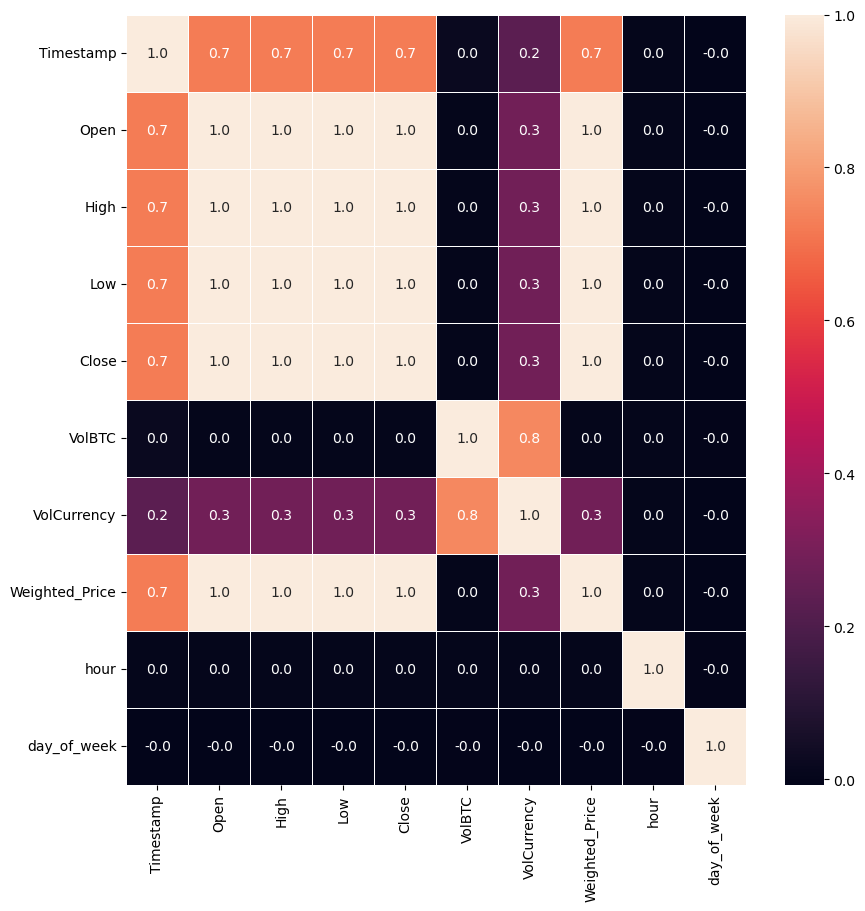

In [42]:
# Heatmap para visualizar a correlação
corr = df_pandas.corr()
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax)

Idealmente queremos alta correlação entre as variáveis de entrada e a variável de saída e baixa correlação entre as variáveis de entrada!

<Figure size 1200x500 with 0 Axes>

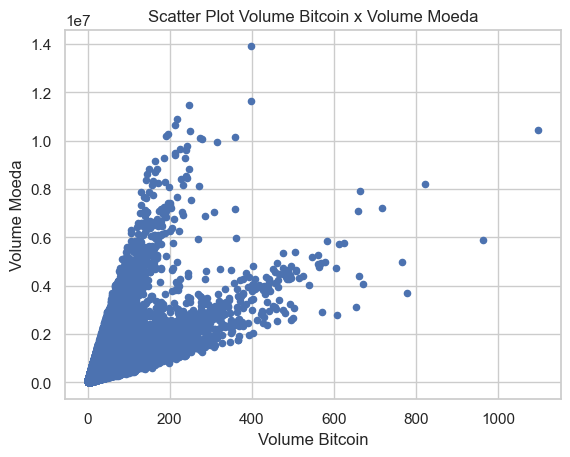

In [43]:
# Scatter Plot Volume Bitcoin x Volume Moeda
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Volume Bitcoin')            
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x Volume Moeda') 
plt.show()

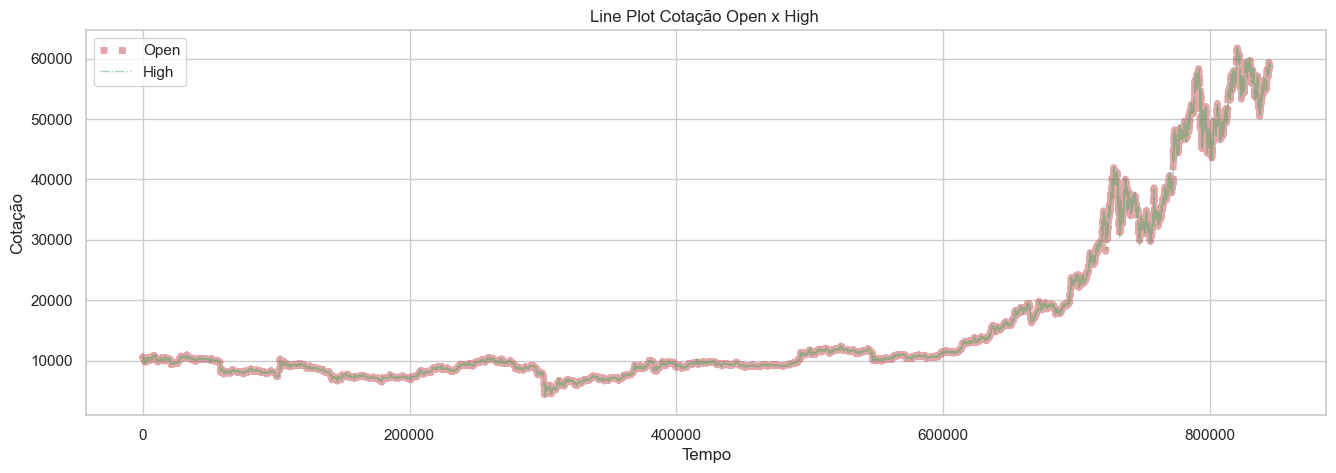

In [44]:
# Line Plot Cotação Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

<AxesSubplot:ylabel='Frequency'>

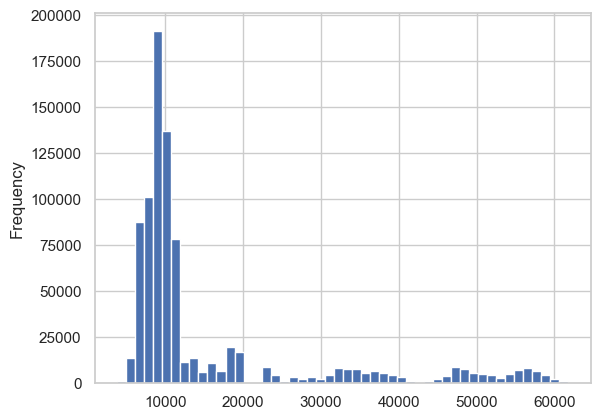

In [45]:
# Histograma da cotação de abertura
df_pandas.Open.plot(kind = 'hist', bins = 50)

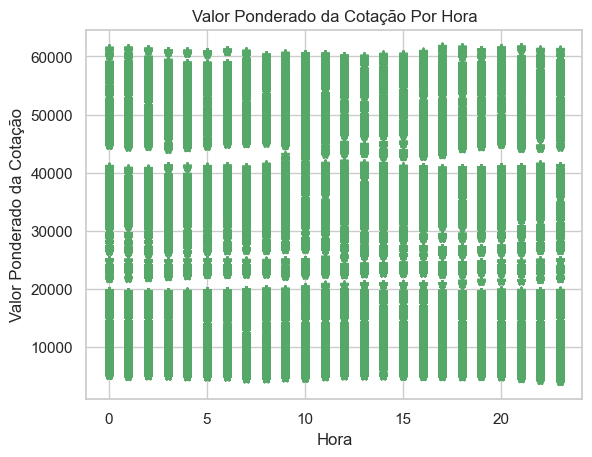

In [46]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(hour, weighted_price , 'g*')
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

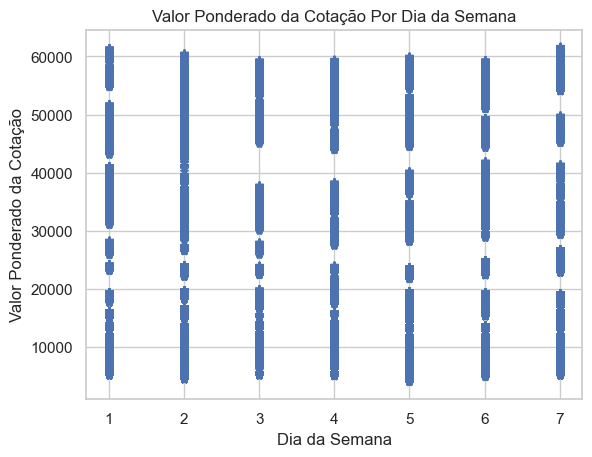

In [47]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

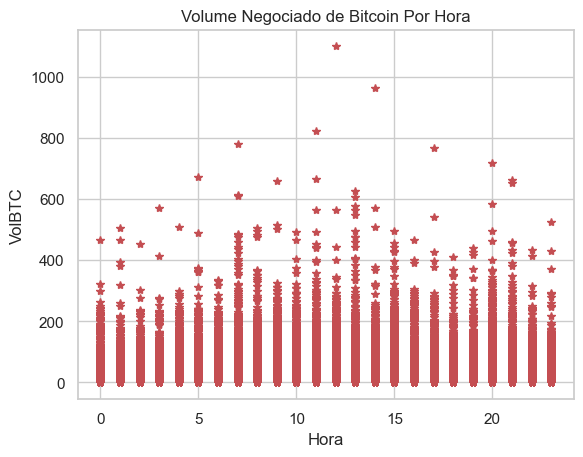

In [48]:
# Plot do VolBTC por hora
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

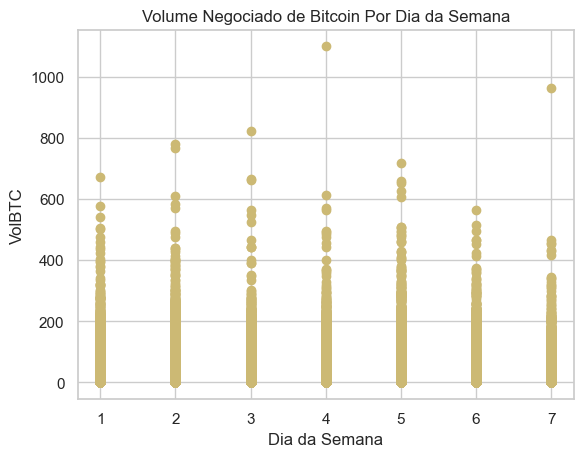

In [49]:
# Plot de VolBTC por dia da semana
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

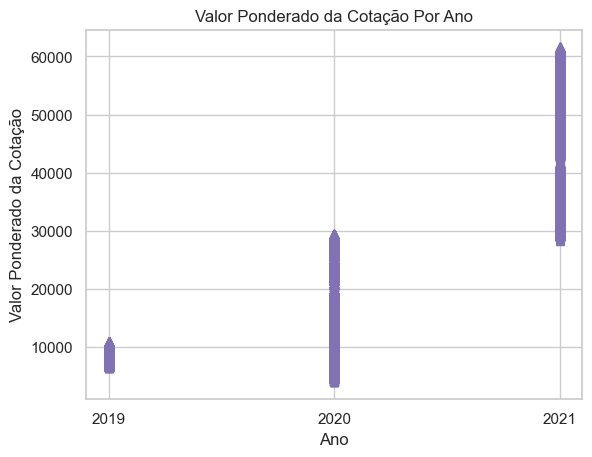

In [50]:
# Plot do valor ponderado da cotação por ano
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

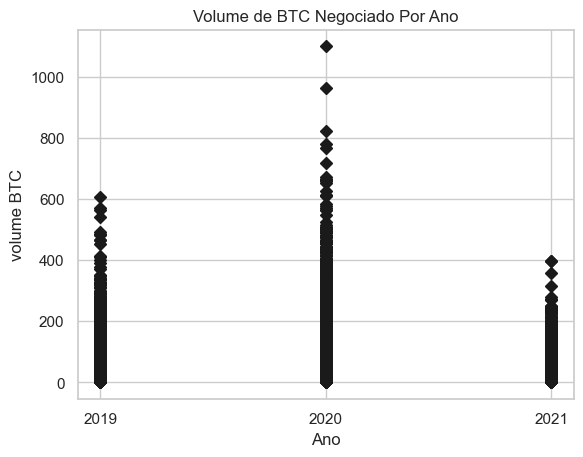

In [51]:
# Plot do Volume por ano
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

## Engenharia de Atributos com PySpark

In [52]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [53]:
# Prepara o vetor de atributos
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'], 
                            outputCol = "features")

In [54]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_bitcoin)

In [55]:
# Visualiza os dados
df_assembled.show(10, truncate = False)

+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+----------------------------------+
|Timestamp |Open    |High    |Low     |Close   |VolBTC    |VolCurrency |Weighted_Price|dateTime           |features                          |
+----------+--------+--------+--------+--------+----------+------------+--------------+-------------------+----------------------------------+
|1565752860|10600.12|10604.77|10597.99|10597.99|0.25703378|2724.7336264|10600.683017  |2019-08-14 00:21:00|[10600.12,0.25703378,2724.7336264]|
|1565752920|10599.3 |10600.6 |10593.47|10600.59|0.21695749|2299.8701409|10600.556546  |2019-08-14 00:22:00|[10599.3,0.21695749,2299.8701409] |
|1565752980|10600.6 |10600.6 |10593.47|10600.0 |1.19255966|12637.004098|10596.538288  |2019-08-14 00:23:00|[10600.6,1.19255966,12637.004098] |
|1565753040|10600.6 |10606.97|10600.6 |10606.97|0.18785115|1991.5564078|10601.779163  |2019-08-14 00:24:00|[10600.6,0.18785115,1991.5564078] |

## Normalização

In [56]:
# Divisão em dados de treino e teste
dados_treino, dados_teste = df_assembled.randomSplit([.7,.3], seed = rnd_seed)

In [57]:
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [58]:
# Cria o scaler
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [59]:
# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

In [60]:
# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

In [61]:
# Transform nos dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [62]:
dados_treino_scaled.select("features", "scaled_features").show(10, truncate = False)

+----------------------------------+-----------------------------------------------------------------+
|features                          |scaled_features                                                  |
+----------------------------------+-----------------------------------------------------------------+
|[10599.3,0.21695749,2299.8701409] |[0.11649836607491428,1.9752993286240806E-4,1.9776370613566613E-4]|
|[10600.6,1.19255966,12637.004098] |[0.11652083265285526,0.001085773860137356,0.0010866463623758944] |
|[10600.6,0.18785115,1991.5564078] |[0.11652083265285526,1.7102985881050235E-4,1.7125203170340864E-4]|
|[10606.14,0.69793703,7397.8216441]|[0.11661657483884981,6.354411723879393E-4,6.361328607150996E-4]  |
|[10598.6,0.06174562,654.90722854] |[0.11648626868679222,5.621618304931706E-5,5.631453763079929E-5]  |
|[10610.0,5.24587582,55657.566048] |[0.11668328329335147,0.004776144356592291,0.004785953301587823]  |
|[10609.98,9.51862038,100892.28535]|[0.11668293765369082,0.00866629499885

In [63]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

## Versão 1 do Modelo de Machine Learning (Benchmark)

In [64]:
# Cria o modelo de regressão
modelo_lr_v1 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price', 
                                 maxIter = 100, 
                                 regParam = 0.3, 
                                 elasticNetParam = 0.8, 
                                 standardization = False))

In [67]:
# Treina o modelo
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

In [75]:
# # Salva o modelo em disco
# modelo_v1.write().overwrite().save('modelos/modelo_1')

## Avaliação do Modelo

In [78]:
# Previsões com dados de teste
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [79]:
previsoes_v1

DataFrame[Timestamp: int, Open: double, High: double, Low: double, Close: double, VolBTC: double, VolCurrency: double, Weighted_Price: double, dateTime: string, features: vector, scaled_features: vector, Predicted_price: double]

In [80]:
# Seleciona as colunas
pred_data_v1 = previsoes_v1.select("Predicted_price", "Weighted_Price").show(10)

Py4JJavaError: An error occurred while calling o895.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 27.0 failed 1 times, most recent failure: Lost task 0.0 in stage 27.0 (TID 51) (JOAOMARCELO executor driver): org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4344)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3549)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [81]:
# Mean Absolute Error
print("Mean Absolute Error (MAE) nos dados de teste: {0}".format(modelo_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) nos dados de teste: 8.529406669516662


In [82]:
# Cria um avaliador para o modelo de regressão
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [83]:
# Aplica o avaliador
rmse_v1 = evaluator.evaluate(previsoes_v1)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v1)

Py4JJavaError: An error occurred while calling o900.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 28.0 failed 1 times, most recent failure: Lost task 0.0 in stage 28.0 (TID 52) (JOAOMARCELO executor driver): org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1261)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1262)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1199)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1193)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1286)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1253)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1239)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1239)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary$lzycompute(RegressionMetrics.scala:70)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary(RegressionMetrics.scala:62)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSerr$lzycompute(RegressionMetrics.scala:74)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSerr(RegressionMetrics.scala:74)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.meanSquaredError(RegressionMetrics.scala:106)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.rootMeanSquaredError(RegressionMetrics.scala:115)
	at org.apache.spark.ml.evaluation.RegressionEvaluator.evaluate(RegressionEvaluator.scala:100)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1261)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1262)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [84]:
# Extrai as previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)

Py4JJavaError: An error occurred while calling o361.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 29.0 failed 1 times, most recent failure: Lost task 3.0 in stage 29.0 (TID 59) (JOAOMARCELO executor driver): org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1261)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1262)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1199)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1193)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1286)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1253)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1239)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1239)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary$lzycompute(RegressionMetrics.scala:70)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary(RegressionMetrics.scala:62)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSreg$lzycompute(RegressionMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSreg(RegressionMetrics.scala:77)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.explainedVariance(RegressionMetrics.scala:88)
	at org.apache.spark.ml.regression.LinearRegressionSummary.<init>(LinearRegression.scala:934)
	at org.apache.spark.ml.regression.LinearRegressionModel.evaluate(LinearRegression.scala:727)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1261)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1262)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [85]:
# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

NameError: name 'pred_results_v1' is not defined

In [86]:
# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v1.predictions.select("Predicted_price").toPandas()

NameError: name 'pred_results_v1' is not defined

In [87]:
# Distribuição dos valores reais x valores previstos
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

NameError: name 'Y' is not defined

In [88]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

NameError: name 'Y' is not defined

<Figure size 1200x700 with 0 Axes>

## Versão 2 do Modelo de Machine Learning (Otimização de Hiperparâmetros)

In [89]:
# Cria o modelo
modelo_lr_v2 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price'))

In [90]:
# Cria um grid para otimização de hiperparâmetros
grid = ParamGridBuilder().addGrid(modelo_lr_v2.maxIter, [50, 100]).build()

In [91]:
# Cria o avaliador (será usado na validação cruzada)
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [92]:
# Cria o CrossValidator
cv = CrossValidator(estimator = modelo_lr_v2, estimatorParamMaps = grid, evaluator = evaluator, parallelism = 2)

In [93]:
# Treina o CrossValidator
cvModel = cv.fit(dados_treino_scaled)

Py4JJavaError: An error occurred while calling o1011.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 30.0 failed 1 times, most recent failure: Lost task 3.0 in stage 30.0 (TID 63) (JOAOMARCELO executor driver): org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:286)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkFileNotFoundException: File file:/C:/JoaoMarcelo/FCD/BigDataRealTimePythonSpark/Cap11/25-Mini-Projeto3/dados/porcao_4.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:286)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)


In [94]:
# Extrai o melhor modelo do CrossValidator
modelo_v2 = cvModel.bestModel

NameError: name 'cvModel' is not defined

In [95]:
# Salva o modelo em disco
modelo_v2.write().overwrite().save("modelos/modelo_v2")

NameError: name 'modelo_v2' is not defined

## Avaliação do Modelo

In [96]:
# Previsões com dados de teste
previsoes_v2 = modelo_v2.transform(dados_teste_scaled)

NameError: name 'modelo_v2' is not defined

In [97]:
# Seleciona as colunas
pred_data_v2 = previsoes_v2.select("Predicted_price", "Weighted_Price").show(10)

NameError: name 'previsoes_v2' is not defined

In [98]:
# Mean Absolute Error
print("MAE: {0}".format(modelo_v2.summary.meanAbsoluteError))

NameError: name 'modelo_v2' is not defined

In [99]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [100]:
# Aplica o avaliador
rmse_v2 = evaluator.evaluate(previsoes_v2)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v2)

NameError: name 'previsoes_v2' is not defined

In [101]:
# Plot dos valores reais x valores previstos

# Extrai as previsões
pred_results_v2 = modelo_v2.evaluate(dados_teste_scaled)

# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v2.predictions.select('Weighted_Price').toPandas()

# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v2.predictions.select("Predicted_price").toPandas()

# Plot
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

NameError: name 'modelo_v2' is not defined

In [102]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

NameError: name 'Y' is not defined

<Figure size 1200x700 with 0 Axes>

## Previsões em Tempo Real

In [103]:
# Novos dados
novos_dados = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [104]:
# Prepara o dataframe do Pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [105]:
# Visualiza
df_novos_dados

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [106]:
# Converte o dataframe do Pandas para dataframe do Spark
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados) 

In [107]:
# Schema
df_novos_dados_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [108]:
# Visualiza
df_novos_dados_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [109]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_novos_dados_spark)

In [110]:
# Visualiza os dados
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [111]:
# Normaliza os dados
df_assembled_scaled = scalerModel.transform(df_assembled)

In [112]:
# Previsões com os novos dados
previsoes = modelo_v1.transform(df_assembled_scaled)

In [113]:
# Imprime as previsões
pred_data = previsoes.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
|20545.354989130603|
| 21619.68044067063|
+------------------+



In [114]:
# Encerra a sessão Spark
spark_session.stop()